In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

## Text Import

In [4]:
## Combing all text file together for training dataset

import glob

read_2013 = glob.glob("C:/Users/James Jia/Desktop/HW3/2013/*.txt")
with open("C:/Users/James Jia/Desktop/HW3/2013.txt","wb") as outfile:
    for f in read_2013:
        with open(f, "rb") as infile:
            content = infile.read()
            outfile.write(content)
            
read_2014 = glob.glob("C:/Users/James Jia/Desktop/HW3/2014/*.txt")
with open("C:/Users/James Jia/Desktop/HW3/2014.txt","wb") as outfile:
    for f in read_2014:
        with open(f, "rb") as infile:
            content = infile.read()
            outfile.write(content)

filenames = ["2013.txt","2014.txt"]
with open("C:/Users/James Jia/Desktop/HW3/raw_text.txt","wb") as outfile:
    for f in filenames:
        with open(f, "rb") as infile:
            content = infile.read()
            outfile.write(content)

In [5]:
text = open("raw_text.txt","r",encoding='utf-8',errors='ignore').read()

## Text Preprocessing

In [6]:
## Tokenization

text = text.replace("\\"," ").replace("\n"," ").replace('"'," ").replace(",","")
text = word_tokenize(text)

In [7]:
## Remove stopwords

stop_word = set(stopwords.words("english"))
text = [i for i in text if not i in stop_word]

In [8]:
## Lematization
lemma = WordNetLemmatizer()
text = [ lemma.lemmatize(token) for token in text ]

In [9]:
## clean tokenized "." and brackets
text = [ token for token in text if token != '.']
text = [ token for token in text if token != '(']
text = [ token for token in text if token != ')']

In [10]:
len(text)

9609708

## Label import

In [71]:
import pandas as pd
ceo = pd.read_csv('C:/Users/James Jia/Desktop/HW3/labels/ceo_clean.csv', header=None,names=['name'])

In [72]:
ceo = ceo.drop_duplicates()
ceo.head(3)

,name
0,Tom Horton
1,Patti Hart
2,Jamie Dimon


In [73]:
## single-name lable does not make sense, remove
ceo['len'] = 0
ceo = ceo.reset_index(drop=True)

for index, row in ceo.iterrows():
    name_arr = row['name'].split()
    length = len(name_arr)
    ceo.iat[index,1] = length

ceo = ceo.loc[ceo["len"] >= 2]
ceo = ceo.reset_index(drop=True)

In [74]:
len(ceo)

1532

In [418]:
company = pd.read_csv('C:/Users/James Jia/Desktop/HW3/labels/companies.csv', header=None,names=['name'])

In [419]:
company = company.drop_duplicates()
company = company.reset_index(drop=True)
company.head(3)

,name
0,Abaxis Inc
1,ACA Financial
2,Alibaba Group Holding Ltd


In [420]:
len(company)

2592

In [421]:
percent = pd.read_csv('C:/Users/James Jia/Desktop/HW3/labels/percentage.csv', encoding="latin-1",header=None,names=['raw'])

In [422]:
percent = percent.drop_duplicates()
percent = percent.reset_index(drop=True)
len(percent.raw)

3837

In [423]:
## Need to remove raw numbers (non-percentage) and replace %
def replace_perc(row):
    value = row['raw'].lower()
    if ("%" not in value) and ("perc" not in value):
        return "X"
    
    if "%" in value:
        return row['raw'].replace("%"," %")
    
    return row['raw']

In [424]:
percent['name'] = percent.apply(replace_perc, axis=1)

In [425]:
percent = percent[percent['name'] != "X"]
percent = percent.reset_index(drop=True)
percent.head()

,raw,name
0,66%,66 %
1,40%,40 %
2,90%,90 %
3,49%,49 %
4,100%,100 %


In [426]:
percent = percent.drop(columns = ['raw'])
len(percent.name)

2368

## Helper Functions

In [338]:
## Helper function 1

## function to locate the 1st position of an exact match
def find_name_match(name, what_to_read):
    name_arr = name.split()
    lead = name_arr[0]
    size = len(name_arr)
    
    txt_length = len(what_to_read)
    
    result = 0
    locs = [i for i, element in enumerate(what_to_read) if element == lead]
    
    ## if doesn't exist, return
    if (len(locs) == 0):
        return result
    
    ## if it's 1-single value, return the first position
    if (size == 1):
        result = locs[0]
        return result
    
    for loc in locs:
        
        ## out of bound check
        if (size > txt_length - loc):
            return result
        
        ## starting from first token --> last token
        pos = 1
        while (pos < size):
            if (what_to_read[loc+pos] == name_arr[pos]):
                pos = pos + 1
            else:
                break
                
        ## find an exaxt match:
        if (pos == size):
            result = loc
            return result
    
    return result

In [182]:
## Helper function 2

## function to create the snippet
def create_snippet(loc, what_to_read):
    length = len(what_to_read)-1
    
    begin = loc - 7
    end = loc + 8
    
    if begin < 0:
        begin = 0
    if end > length:
        end = length
        
    arr_snippet = what_to_read[begin:end]
    txt_snippet = ''
    for token in arr_snippet:
        txt_snippet = txt_snippet + " " + token
    
    return txt_snippet

## PART I -- CEO

In [77]:
## create snippet column in CEO
ceo['snippet'] = ''

for index, row in ceo.iterrows():
    
    ## status monitor
    if (index % 500 == 0):
        print(index)
        
    result = find_name_match(row['name'], text)
    if (result != 0):
        sni = create_snippet(result, text)
        ceo.iat[index,2] = sni

0
500
1000
1500


In [78]:
ceo = ceo.drop(columns=['len'])

In [79]:
ceo.head()

,name,snippet
0,Tom Horton,Airways CEO Doug Parker American 's CEO Tom H...
1,Patti Hart,laying course On February 1st IGT CEO Patti H...
2,Jamie Dimon,three come Wall Street The list start Jamie D...
3,Steve Cohen,'s chief investment office course move Facebo...
4,Tim Cook,: In press release announcing earnings CEO Ti...


In [80]:
## features exploration

for index, row in ceo.iterrows():
    if (index % 60 == 0):
        print(row['snippet'])

 Airways CEO Doug Parker American 's CEO Tom Horton serve chairman new company mid-2014 people
 lost job manufacturing industry said ADP 's Carlos Rodriguez Here 's break company size :

 pass Sony Pictures Entertainment Co-CEOs Michael Lynton Amy Pascal called executive responsible debacle Loeb add
 demand Cisco $ 46 billion cash CEO John Chambers say longer willing use acquire U.S.
 Press host held high-capacity magazine NRA CEO Wayne LaPierre 's appearance show last month On
 fiscal 2015 begin October year Coca-Cola CEO Muhtar Kent said call deal would give company
 beginning leave footprint wealth management sphere But John Rourke CEO NYC-based Gotham Tech Labs think

 demand That enterprise called BTC China CEO Bobby Lee hail Yahoo ! Walmart China Oh
 2012 After giving away $ 28 billion Bill Gates longer third-richest man world He 's
 onto Iranian tanker He Tri-Ocean 's CEO Mohammed el-Ansary respond request Reuters review document seen
 year impress including top tech CEOs like S

#### Creating Negative Samples

In [81]:
politician = pd.read_csv('C:/Users/James Jia/Desktop/HW3/labels/politician.csv', header=None,names=['name'])

In [82]:
politician.head(3)

,name
0,Alan Franken
1,Amy Klobuchar
2,Angus King


In [83]:
politician['present'] = 0
politician['snippet'] = ''

for index, row in politician.iterrows():
        
    result = find_name_match(row['name'], text)
    if (result != 0):
        politician.iat[index,1] = result
        sni = create_snippet(result, text)
        politician.iat[index,2] = sni

In [84]:
politician.head(10)

,name,present,snippet
0,Alan Franken,0,
1,Amy Klobuchar,3341337,Independent Heidi Heitkamp D-N.D. Mark Pryor ...
2,Angus King,2296345,R-Ariz Washington Democrat Maria Cantwell Mai...
3,Barbara Mikulski,771540,across board In letter Senate Appropriations ...
4,Barbara Boxer,343007,n't announced 'll run re-election yet Senator...
5,Benjamin Cardin,0,
6,Bernard Sanders,0,
7,Bill Nelson,3658715,Department five Senators — Elizabeth Warren D...
8,Bob Corker,434747,new friend across aisle Senate : Sen. Bob Cor...
9,Brian Schatz,0,


In [88]:
len(politician.name)

724

In [91]:
## remove ones not present
politician = politician[politician['present'] != 0]
politician = politician.reset_index(drop=True)

In [92]:
politician

,name,present,snippet
0,Amy Klobuchar,3341337,Independent Heidi Heitkamp D-N.D. Mark Pryor ...
1,Angus King,2296345,R-Ariz Washington Democrat Maria Cantwell Mai...
2,Barbara Mikulski,771540,across board In letter Senate Appropriations ...
3,Barbara Boxer,343007,n't announced 'll run re-election yet Senator...
4,Bill Nelson,3658715,Department five Senators — Elizabeth Warren D...
...,...,...,...
258,Najib Razak,3208565,Filipino-Americans enriched country And Malay...
259,Mark Rutte,1801770,speak ” said And Dutch Prime Minister Mark Ru...
260,Lee Hsien Loong,4132580,peaceful worker belligerent mob The prime min...
261,Mariano Rajoy,465394,; @ daraconn2A photoshopped image Spanish PM ...


In [93]:
## features exploration

for index, row in politician.iterrows():
    if (index % 50 == 0):
        print(row['snippet'])

 Independent Heidi Heitkamp D-N.D. Mark Pryor D-Ark Amy Klobuchar D-Minn. Angus King I-Maine Joe Donnelly
 — Elizabeth Warren D-MA Bill Nelson D-FL Martin Heinrich D-NM Sheldon Whitehouse D-RI — urging
 cover Five Easy Pieces united first time Chris Collins executive editor Asia becomes Senior Executive
 Gregory Meyer Jamie Smyth report InTrade founder John Delaney failed adequately report $ 2.6 million
 headline swallow Breaking : Leaving mtg Rep. Spencer Bachus say deal go back Senate There
 opposition protest since Oct. 26 Prime Minister Sheikh Hasina want form all-party caretaker government hold


In [94]:
politician = politician.drop(columns=['present'])

In [97]:
ceo['label'] = 1
politician['label'] = 0

In [102]:
## Economists / doctors
economist_loc = [i for i, element in enumerate(text) if element == "Dr."]
len(economist_loc)

676

In [107]:
dr = pd.DataFrame(economist_loc,columns=["name"])

dr['snippet'] = ''

for index, row in dr.iterrows():
    
    sni = create_snippet(row['name'], text)
    dr.iat[index,1] = sni

In [112]:
dr.iloc[15,1]

' rising cost care In JAMA Internal Medicine Dr. Allan Prochazka Dr. Tanner Caverly write General'

In [117]:
dr['label'] = 0
dr = dr.drop(columns=['name'])

In [129]:
## editors
editor_loc = [i for i, element in enumerate(text) if (element == "editor") or (element == "Editor")]
len(editor_loc)

647

In [130]:
editor = pd.DataFrame(editor_loc,columns=["name"])

editor['snippet'] = ''

for index, row in editor.iterrows():
    
    sni = create_snippet(row['name'], text)
    editor.iat[index,1] = sni

editor['label'] = 0
editor = editor.drop(columns=['name'])
editor.head(3)

,snippet,label
0,player country almost investor Business Insid...,0
1,Haigh Sydney ahaigh1 @ bloomberg.net To conta...,0
2,Time Warner deprived New York watching BI edi...,0


In [138]:
editor.iloc[60,0]

" dramatic report : Faisal Islam — economics editor U.K. 's Channel 4 — report 's"

In [139]:
ceo = ceo.drop(columns=['name'])
politician = politician.drop(columns=['name'])

In [148]:
## Combining to 1 training dataframe
training_data = pd.concat([ceo, politician, dr, editor])

In [150]:
len(training_data.snippet)

3118

#### Creating features

In [151]:
## Features:

## f1 : contain the word "ceo" or "CEO"
def ceo_f1(row):
    snippet = row['snippet']
    result = re.findall(r'[Cc][Ee][Oo]', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0

## f2 : contain the word "executive"
def ceo_f2(row):
    snippet = row['snippet']
    result = re.findall(r'[Ee]xecutive', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0
    
## f3 : contain the word "lead"
def ceo_f3(row):
    snippet = row['snippet']
    result = re.findall(r'[Ll]ead', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0
    
## f4 : contain the word "said"
def ceo_f4(row):
    snippet = row['snippet']
    result = re.findall(r'[Ss]aid', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0

## f5 : contain the "$" symbol
def ceo_f5(row):
    snippet = row['snippet']
    result = re.findall(r'\$', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0
    
## f6 : contain the "'s'" snippet
def ceo_f6(row):
    snippet = row['snippet']
    result = re.findall(r'\'s', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0

In [152]:
training_data

,snippet,label,f1,f2,f3,f4,f5,f6
0,Airways CEO Doug Parker American 's CEO Tom H...,1,0,0,0,0,0,0
1,laying course On February 1st IGT CEO Patti H...,1,0,0,0,0,0,0
2,three come Wall Street The list start Jamie D...,1,0,0,0,0,0,0
3,'s chief investment office course move Facebo...,1,0,0,0,0,0,0
4,: In press release announcing earnings CEO Ti...,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
642,go Also feel free shoot email deputy editor S...,0,0,0,0,0,0,0
643,interested Facebook 's app recommendation App...,0,0,0,0,0,0,0
644,CNN Nick Trend Telegraph Travel 's consumer e...,0,0,0,0,0,0,0
645,& amp ; Country magazine 's associate editor ...,0,0,0,0,0,0,0


In [155]:
training_data['f1'] = training_data.apply(ceo_f1, axis=1)
training_data['f2'] = training_data.apply(ceo_f2, axis=1)
training_data['f3'] = training_data.apply(ceo_f3, axis=1)
training_data['f4'] = training_data.apply(ceo_f4, axis=1)
training_data['f5'] = training_data.apply(ceo_f5, axis=1)
training_data['f6'] = training_data.apply(ceo_f6, axis=1)

In [156]:
training_data

,snippet,label,f1,f2,f3,f4,f5,f6
0,Airways CEO Doug Parker American 's CEO Tom H...,1,1,0,0,0,0,1
1,laying course On February 1st IGT CEO Patti H...,1,1,0,0,0,0,0
2,three come Wall Street The list start Jamie D...,1,0,0,0,0,1,0
3,'s chief investment office course move Facebo...,1,0,0,0,0,0,1
4,: In press release announcing earnings CEO Ti...,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
642,go Also feel free shoot email deputy editor S...,0,0,0,0,0,0,0
643,interested Facebook 's app recommendation App...,0,0,0,0,0,0,1
644,CNN Nick Trend Telegraph Travel 's consumer e...,0,0,0,0,1,0,1
645,& amp ; Country magazine 's associate editor ...,0,0,0,0,0,0,1


#### Train Logit Model

In [157]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

In [158]:
X = training_data[['f1','f2','f3','f4','f5','f6']]
Y = training_data[['label']]

In [168]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size = 0.9)

In [170]:
ceo_logit = LogisticRegression()
ceo_logit.fit(X_train, Y_train.values.ravel())
Y_pred = ceo_logit.predict(X_test)

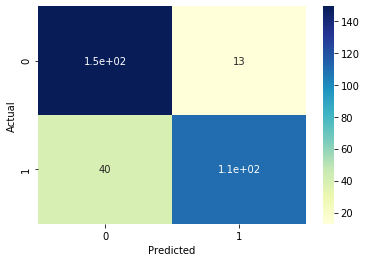

In [178]:
ceo_matrix = pd.crosstab(Y_test.values.ravel(), Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(ceo_matrix, annot=True, cmap="YlGnBu")

In [179]:
metrics.accuracy_score(Y_test.values.ravel(), Y_pred)

0.8301282051282052

In [498]:
ceo_logit.coef_

array([[ 4.85556984,  1.75995415,  0.16442555,  0.38710025,  1.10835805,
        -0.83569693]])

#### Raw data Results

In [185]:
## Final result:
ceo_name = []
ceo_snippet = []

import spacy

In [186]:
## 2013
## looper over all files

text_2013 = glob.glob("C:/Users/James Jia/Desktop/HW3/2013/*.txt")

looper = 0

for file_dir in text_2013:
    
    if (looper % 30 == 0):
        print(looper)
    looper = looper + 1
    
    toread = open(file_dir, "r", encoding='utf-8', errors='ignore').read()
    
    ## getting the spacy NER results
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(toread)
    
    ## text processing and tokenizing:
    toread_token = toread.replace("\\"," ").replace("\n"," ").replace('"'," ").replace(",","")
    toread_token = word_tokenize(toread_token)
    toread_token = [i for i in toread_token if not i in stop_word]
    toread_token = [ lemma.lemmatize(token) for token in toread_token ]
    toread_token = [ token for token in toread_token if token != '.']
    toread_token = [ token for token in toread_token if token != '(']
    toread_token = [ token for token in toread_token if token != ')']
    
    ## adding new names + create snippets
    for ent in doc.ents:
        tokens = ent.text.split()
        name = ent.text
        if (len(tokens) > 1) and (ent.label_ == "PERSON") and (name not in ceo_name):
            ceo_name.append(name)
            loc = find_name_match(name, toread_token)
            sni = create_snippet(loc, toread_token)
            ceo_snippet.append(sni)    

0
30
60
90
120
150
180
210
240
270
300
330
360


In [189]:
## 2014
## looper over all files

text_2014 = glob.glob("C:/Users/James Jia/Desktop/HW3/2014/*.txt")

looper = 0

for file_dir in text_2014:
    
    if (looper % 30 == 0):
        print(looper)
    looper = looper + 1
    
    toread = open(file_dir, "r", encoding='utf-8', errors='ignore').read()
    
    ## getting the spacy NER results
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(toread)
    
    ## text processing and tokenizing:
    toread_token = toread.replace("\\"," ").replace("\n"," ").replace('"'," ").replace(",","")
    toread_token = word_tokenize(toread_token)
    toread_token = [i for i in toread_token if not i in stop_word]
    toread_token = [ lemma.lemmatize(token) for token in toread_token ]
    toread_token = [ token for token in toread_token if token != '.']
    toread_token = [ token for token in toread_token if token != '(']
    toread_token = [ token for token in toread_token if token != ')']
    
    ## adding new names + create snippets
    for ent in doc.ents:
        tokens = ent.text.split()
        name = ent.text
        if (len(tokens) > 1) and (ent.label_ == "PERSON") and (name not in ceo_name):
            ceo_name.append(name)
            loc = find_name_match(name, toread_token)
            sni = create_snippet(loc, toread_token)
            ceo_snippet.append(sni)    

0
30
60
90
120
150
180
210
240
270
300
330
360


In [190]:
len(ceo_name)

41731

In [208]:
ceo_df = pd.DataFrame(list(zip(ceo_name,ceo_snippet)), 
                      columns =['name', 'snippet'])
for index, row in ceo_df.iterrows():
    if ("'s" in row['name']):
        ceo_df = ceo_df.drop(index)

In [211]:
ceo_df = ceo_df.reset_index(drop=True)
ceo_df.head(5)

,name,snippet
0,Mitch McConnell,bill orchestrated White House Senate Minority...
1,John Boehner,Mitch McConnell conservative railing GOP Hous...
2,Mitt Romney,regard America land maker taker Congress sock...
3,Fred Wilson,would paid Tax Policy Center Venture capitali...
4,Brad Burnham,Square delivered past 5 year fluke partner Br...


In [212]:
ceo_df['f1'] = ceo_df.apply(ceo_f1, axis=1)
ceo_df['f2'] = ceo_df.apply(ceo_f2, axis=1)
ceo_df['f3'] = ceo_df.apply(ceo_f3, axis=1)
ceo_df['f4'] = ceo_df.apply(ceo_f4, axis=1)
ceo_df['f5'] = ceo_df.apply(ceo_f5, axis=1)
ceo_df['f6'] = ceo_df.apply(ceo_f6, axis=1)

In [213]:
ceo_df.head(5)

,name,snippet,f1,f2,f3,f4,f5,f6
0,Mitch McConnell,bill orchestrated White House Senate Minority...,0,0,1,0,0,0
1,John Boehner,Mitch McConnell conservative railing GOP Hous...,0,0,1,0,0,1
2,Mitt Romney,regard America land maker taker Congress sock...,0,0,0,0,0,1
3,Fred Wilson,would paid Tax Policy Center Venture capitali...,0,0,0,0,0,0
4,Brad Burnham,Square delivered past 5 year fluke partner Br...,0,0,0,0,0,0


In [214]:
ceo_df_x = ceo_df[['f1','f2','f3','f4','f5','f6']]

In [216]:
ceo_df_y = ceo_logit.predict(ceo_df_x)

In [220]:
ceo_df['decision'] = ceo_df_y

In [221]:
ceo_df.head(5)

,name,snippet,f1,f2,f3,f4,f5,f6,decision
0,Mitch McConnell,bill orchestrated White House Senate Minority...,0,0,1,0,0,0,0
1,John Boehner,Mitch McConnell conservative railing GOP Hous...,0,0,1,0,0,1,0
2,Mitt Romney,regard America land maker taker Congress sock...,0,0,0,0,0,1,0
3,Fred Wilson,would paid Tax Policy Center Venture capitali...,0,0,0,0,0,0,0
4,Brad Burnham,Square delivered past 5 year fluke partner Br...,0,0,0,0,0,0,0


In [222]:
ceo_df_result = ceo_df[ceo_df['decision'] == 1]

In [223]:
ceo_df_result.head(5)

,name,snippet,f1,f2,f3,f4,f5,f6,decision
58,Jeff Immelt,Industrial Renaissance In December issue The ...,1,0,0,0,0,0,1
65,George W. Bush,would without Fiscal Cliff deal $ 675K George...,0,0,0,0,1,0,1
88,Anand Nallathambi,term number unit dollar represent ” said Anan...,1,0,0,1,0,0,1
89,Mark Mobius,Global Investment Adventures Emerging Markets...,0,1,0,0,0,0,1
130,Jorge Piedrahitatold Bloomberg,40 basis point today Torino Capital CEO Jorge...,1,0,0,0,0,0,1


In [227]:
## Which features are more ubiqitous?

ceo_feature = ['f1','f2','f3','f4','f5','f6']
for i in ceo_feature:
    print(ceo_df_result[i].mean())

0.4009836914315299
0.2780222624902925
0.016308568470100957
0.19000776598498575
0.3595651048407973
0.13952886357753042


In [350]:
len(ceo_df_result.name)

3863

In [228]:
## output

ceo_df_result.to_csv('C:/Users/James Jia/Desktop/HW3/output/all_ceo.csv', 
                    columns = ['name'], index=False, header=False)

## PART II -- COMPANY

In [197]:
## create snippet column in company
company['snippet'] = ''

for index, row in company.iterrows():
    
    ## status monitor
    if (index % 500 == 0):
        print(index)
        
    result = find_name_match(row['name'], text)
    if (result != 0):
        sni = create_snippet(result, text)
        company.iat[index,1] = sni

0
500
1000
1500
2000
2500


In [231]:
company = company[company['snippet'] != '']

In [233]:
company = company.reset_index(drop=True)

In [235]:
## feature exploration
for index, row in company.iterrows():
    if (index % 90 == 0):
        print(row['snippet'])

 illegally tipping brother earnings medical device company Abaxis Inc Her brother accused passing information former
 fourth quarter addition already disclosed Herbalife include News Corp Louisiana PAC Corp. International Paper Illumina
 supermarket Steve Brazier CEO market research firm Canalys said report last year Even mighty Walmart
 Sen. John McCain R-Ariz Washington Democrat Maria Cantwell Maine Independent Angus King co-sponsoring bill You
 right They among Hollywood glitterati bought dream Fisker Automotive gas-thrifty rule-breaking Karma kick sand face
 trade $ 109 Shares two sand miner U.S. Silica Holdings Inc Hi Crush Partners LP
 NYC 's nightclub supplement mixer given can Red Bull already available certain bottle service table
 Debes technology veteran operating partner buyout firm Advent International Corp. PLATONIC GUARDIANS ? Some conflict
 fascination New York tabloid WHO 'S THIS YAHOO ? Tumblr allows user create simple blog
 head Mainstreet Bank bank 's holding compan

#### Create Negative Samples

In [254]:
## Council, foundation, association, community
org1_loc = [i for i, element in enumerate(text) if 
            (element == "Council") or (element == "Foundation") or
           (element == "Association")]

In [255]:
len(org1_loc)

1999

In [256]:
org2_loc = [i for i, element in enumerate(text) if
           (element == "WTO") or (element == "UN") or (element == "WHO")
           or (element == "AIESEC") or (element == "NATO") or 
           (element == "ASEAN")]

In [257]:
len(org2_loc)

445

In [258]:
org_loc = org1_loc + org2_loc

In [259]:
len(org_loc)

2444

In [261]:
org = pd.DataFrame(org_loc,columns=["name"])

org['snippet'] = ''

org_snippet = []

for index, row in org.iterrows():
    
    sni = create_snippet(row['name'], text)
    org_snippet.append(sni)

In [263]:
org['snippet'] = org_snippet

In [264]:
org.head(5)

,name,snippet
0,7562,money away He The Bill Melinda Gates Foundati...
1,16620,another day Here welfare chart : Heritage Fou...
2,24395,& nbsp ; The Club Growth Heritage Foundation ...
3,30654,Precipice The presentation delivered North Ca...
4,34947,rate Pointing recent decision Financial Stabi...


In [265]:
org = org.drop(columns=['name'])

In [266]:
## feature exploration
for index, row in org.iterrows():
    if (index % 200 == 0):
        print(row['snippet'])

 money away He The Bill Melinda Gates Foundation working $ 36.2 billion endowment Gates But
 EU leader including Herman Van Rompuy European Council president Christine Lagarde IMF ’ managing director
 full letter It 's odd development since Foundation n't actually perform wire transfer rather serf
 option contract That 's worked Futures Trading Association launch educational effort help individual investor trade
 big development section Brooklyn 10 year City Council including Atlantic Yards development recently opened Barclays
 agency reported late Saturday citing China Cuisine Association It give growth pace earlier year Restaurant
 including time spent senior person Treasury member Council Economic Advisors He well positioned capitalize financially
 incredible swing Jason Furman chairman White House'sof Council Economic Advisers said 's biggest revision roughly
 Reuters - The U.S. Financial Stability Oversight Council closed evidentiary record determine whether insurance firm
 's goo

In [267]:
company = company.drop(columns=['name'])
company['label'] = 1
org['label'] = 0

In [268]:
## Combining to 1 training dataframe
co_training_data = pd.concat([company, org])

In [269]:
len(co_training_data.snippet)

4612

#### Creating features

In [270]:
## Features:

## f1 : contain the word "ceo" or "CEO"
def co_f1(row):
    snippet = row['snippet']
    result = re.findall(r'[Cc][Ee][Oo]', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0

## f2 : contain the words:
## "Inc", "Corp", "Company", "Co", "Group","Ltd", "LLC"
def co_f2(row):
    snippet = row['snippet']
    result = []
    result = result + re.findall(r'Inc', snippet)
    result = result + re.findall(r'Corp', snippet)
    result = result + re.findall(r'Company', snippet)
    result = result + re.findall(r'Co', snippet)
    result = result + re.findall(r'Group', snippet)
    result = result + re.findall(r'Ltd', snippet)
    result = result + re.findall(r'LLC', snippet)
    length = len(result)
    return length
    
## f3 : contain the words:
## "Media", "Entertainment", "Management", "Capital", "Bank"
def co_f3(row):
    snippet = row['snippet']
    result = []
    result = result + re.findall(r'Media', snippet)
    result = result + re.findall(r'Entertainment', snippet)
    result = result + re.findall(r'Management', snippet)
    result = result + re.findall(r'Capital', snippet)
    result = result + re.findall(r'Bank', snippet)
    length = len(result)
    return length
    
## f4 : contain numbers
def co_f4(row):
    snippet = row['snippet']
    result = re.findall(r'[0-9]+', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0

## f5 : contain the "$" symbol
def co_f5(row):
    snippet = row['snippet']
    result = re.findall(r'\$', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0
    
## f6 : how many all-caps (at least 2 letters)
def co_f6(row):
    snippet = row['snippet']
    result = re.findall(r'[A-Z][A-Z]+(?=[\ \t\n\?\!\;])', snippet)
    length = len(result)
    return length

In [271]:
co_training_data['f1'] = co_training_data.apply(co_f1, axis=1)
co_training_data['f2'] = co_training_data.apply(co_f2, axis=1)
co_training_data['f3'] = co_training_data.apply(co_f3, axis=1)
co_training_data['f4'] = co_training_data.apply(co_f4, axis=1)
co_training_data['f5'] = co_training_data.apply(co_f5, axis=1)
co_training_data['f6'] = co_training_data.apply(co_f6, axis=1)

In [272]:
co_training_data

,snippet,label,f1,f2,f3,f4,f5,f6
0,illegally tipping brother earnings medical de...,1,0,1,0,0,0,0
1,In 2012 According court filing bond insurer A...,1,0,0,0,1,0,1
2,might come way HONG KONG Reuters - Alibaba Gr...,1,0,2,0,0,0,2
3,candidate top job company including BlackRock...,1,0,2,0,0,0,0
4,Jan Hatzius : NEW YORK Reuters - American Int...,1,0,2,0,0,0,2
...,...,...,...,...,...,...,...,...
2439,WTO 2012 Since original investigation Russia ...,0,0,0,0,1,0,2
2440,In case imposing non-market economy rate inco...,0,0,0,0,0,0,1
2441,name Such deal easier get done universal WTO ...,0,0,0,0,0,0,1
2442,WTO deal They also tend go deeper WTO effort ...,0,0,0,0,0,0,2


#### Train Logit Model

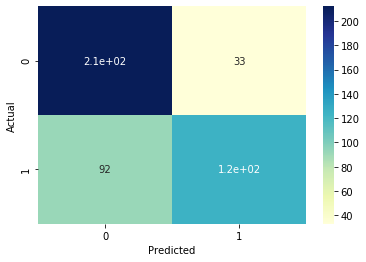

In [273]:
X = co_training_data[['f1','f2','f3','f4','f5','f6']]
Y = co_training_data[['label']]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size = 0.9)
co_logit = LogisticRegression()
co_logit.fit(X_train, Y_train.values.ravel())
Y_pred = co_logit.predict(X_test)
co_matrix = pd.crosstab(Y_test.values.ravel(), Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(co_matrix, annot=True, cmap="YlGnBu")

In [274]:
metrics.accuracy_score(Y_test.values.ravel(), Y_pred)

0.7294372294372294

In [497]:
co_logit.coef_

array([[ 2.74735559,  1.00180651,  0.70953877, -0.08538141,  1.29224194,
         0.03083119]])

#### Raw Data Results

In [340]:
## Final result:
co_name = []
co_snippet = []

In [341]:
## 2013
## looper over all files

text_2013 = glob.glob("C:/Users/James Jia/Desktop/HW3/2013/*.txt")

looper = 0

for file_dir in text_2013:
    
    if (looper % 30 == 0):
        print(looper)
    looper = looper + 1
    
    toread = open(file_dir, "r", encoding='utf-8', errors='ignore').read()
    
    ## getting the spacy NER results
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(toread)
    
    ## text processing and tokenizing:
    toread_token = toread.replace("\\"," ").replace("\n"," ").replace('"'," ").replace(",","")
    toread_token = word_tokenize(toread_token)
    toread_token = [i for i in toread_token if not i in stop_word]
    toread_token = [ lemma.lemmatize(token) for token in toread_token ]
    toread_token = [ token for token in toread_token if token != '.']
    toread_token = [ token for token in toread_token if token != '(']
    toread_token = [ token for token in toread_token if token != ')']
    
    ## adding new names + create snippets
    for ent in doc.ents:
        tokens = ent.text.split()
        name = ent.text
        if (ent.label_ == "ORG") and (name not in co_name):
            co_name.append(name)
            loc = find_name_match(name, toread_token)
            sni = create_snippet(loc, toread_token)
            co_snippet.append(sni)    

0
30
60
90
120
150
180
210
240
270
300
330
360


In [342]:
## 2014
## looper over all files

text_2014 = glob.glob("C:/Users/James Jia/Desktop/HW3/2014/*.txt")

looper = 0

for file_dir in text_2014:
    
    if (looper % 30 == 0):
        print(looper)
    looper = looper + 1
    
    toread = open(file_dir, "r", encoding='utf-8', errors='ignore').read()
    
    ## getting the spacy NER results
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(toread)
    
    ## text processing and tokenizing:
    toread_token = toread.replace("\\"," ").replace("\n"," ").replace('"'," ").replace(",","")
    toread_token = word_tokenize(toread_token)
    toread_token = [i for i in toread_token if not i in stop_word]
    toread_token = [ lemma.lemmatize(token) for token in toread_token ]
    toread_token = [ token for token in toread_token if token != '.']
    toread_token = [ token for token in toread_token if token != '(']
    toread_token = [ token for token in toread_token if token != ')']
    
    ## adding new names + create snippets
    for ent in doc.ents:
        tokens = ent.text.split()
        name = ent.text
        if (ent.label_ == "ORG") and (name not in co_name):
            co_name.append(name)
            loc = find_name_match(name, toread_token)
            sni = create_snippet(loc, toread_token)
            co_snippet.append(sni)    

0
30
60
90
120
150
180
210
240
270
300
330
360


In [343]:
len(co_name)

61809

In [345]:
co_df = pd.DataFrame(list(zip(co_name,co_snippet)), 
                      columns =['name', 'snippet'])

In [346]:
co_df.head(5)

,name,snippet
0,PMI,Earlier today strong South Korean PMI report ...
1,House,PMI 47.4 50.6 From report : With House prepar...
2,Senate,From report : With House prepared vote Senate...
3,the White House,Earlier today strong South Korean PMI report The
4,GOP House,Senate Minority Leader Mitch McConnell conser...


In [347]:
co_df['f1'] = co_df.apply(co_f1, axis=1)
co_df['f2'] = co_df.apply(co_f2, axis=1)
co_df['f3'] = co_df.apply(co_f3, axis=1)
co_df['f4'] = co_df.apply(co_f4, axis=1)
co_df['f5'] = co_df.apply(co_f5, axis=1)
co_df['f6'] = co_df.apply(co_f6, axis=1)

In [348]:
co_df_x = co_df[['f1','f2','f3','f4','f5','f6']]
co_df_y = co_logit.predict(co_df_x)
co_df['decision'] = co_df_y
co_df_result = co_df[co_df['decision'] == 1]
co_feature = ['f1','f2','f3','f4','f5','f6']
for i in co_feature:
    print(co_df_result[i].mean())

0.16957999514445254
1.1020878854090799
0.3026219956300073
0.49902889050740473
0.3877154649186696
0.6689730517115805


In [349]:
len(co_df_result.name)

8238

In [351]:
## output

co_df_result.to_csv('C:/Users/James Jia/Desktop/HW3/output/all_company.csv', 
                    columns = ['name'], index=False, header=False)

## PART III -- PERCENTAGE

In [428]:
## create snippet column in percentage values
percent['snippet'] = ''

snippet = []

for index, row in percent.iterrows():
    
    ## status monitor
    if (index % 500 == 0):
        print(index)
    
    result = find_name_match(row['name'], text)
    if (result != 0):
        sni = create_snippet(result, text)
    else:
        sni = ''
    snippet.append(sni)

0
500
1000
1500
2000


In [430]:
percent['snippet'] = snippet
len(percent.name)

2368

In [431]:
percent = percent[percent['snippet'] != '']
percent = percent.reset_index(drop=True)
len(percent.name)

1777

In [432]:
percent.head(5)

,name,snippet
0,66 %,tech sector whole—the Nasdaq actually histori...
1,40 %,bear market United States The Nasdaq still 40...
2,90 %,'s buying pricey item ? Wiley say 90 % sale c...
3,49 %,acquire Zipcar $ 12.25 per share cash 49 % pr...
4,100 %,Fiscal Cliff fight since tax n't rise 100 % t...


In [433]:
## features exploration

for index, row in percent.iterrows():
    if (index % 60 == 0):
        print(row['snippet'])

 tech sector whole—the Nasdaq actually historically positive 66 % time period Seasonal Odds When following
 500 million equity Supervalu share collapsed nearly 100 percent since June 2007 high thanks competition
 electric car reach 440000 unit 2012 -- 73 % improvement 2011 reaching 850000 unit sale
 second-largest car maker said sale December slid 2.5 percent 47833 car year earlier But Ford
 Company $ 2 billion investment empire exchange 5.63 % stake EBX However Mubadala 's investment
 That confidence may soon start translating hiring Eighty percent wealthy business owner say plan recruit
 S & amp ; P 500 point half percent new all-time high Mainstream market maven
 500 climbed 128 percent period earnings grew 129 percent Yet pundit pointing easy monetary continue
 today 2 hour trading intra-day range SPY 0.27 % Should hold would 4th narrowest intra-day
 benchmark FTSE 100 index fell 42.14 point 0.66 percent 6358.31 point 8:40 On Saturday Beijing
 Cap Bull 3X Shares gross expense ratio

#### Create negative samples

In [434]:
spacy_percentage = []
spacy_percentage_snippet = []
spacy_cardinal = []
spacy_cardinal_snippet = []

In [436]:
## 2013
## looper over all files

text_2013 = glob.glob("C:/Users/James Jia/Desktop/HW3/2013/*.txt")

looper = 0

for file_dir in text_2013:
    
    if (looper % 30 == 0):
        print(looper)
    looper = looper + 1
    
    toread = open(file_dir, "r", encoding='utf-8', errors='ignore').read()
    
    ## getting the spacy NER results
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(toread)
    
    ## text processing and tokenizing:
    toread_token = toread.replace("\\"," ").replace("\n"," ").replace('"'," ").replace(",","")
    toread_token = word_tokenize(toread_token)
    toread_token = [i for i in toread_token if not i in stop_word]
    toread_token = [ lemma.lemmatize(token) for token in toread_token ]
    toread_token = [ token for token in toread_token if token != '.']
    toread_token = [ token for token in toread_token if token != '(']
    toread_token = [ token for token in toread_token if token != ')']
    
    ## adding new names + create snippets
    for ent in doc.ents:
        tokens = ent.text.split()
        name = ent.text
        if (ent.label_ == "PERCENT") and (name not in spacy_percentage):
            spacy_percentage.append(name)
            loc = find_name_match(name, toread_token)
            sni = create_snippet(loc, toread_token)
            spacy_percentage_snippet.append(sni)
        elif (ent.label_ == "CARDINAL") and (name not in spacy_cardinal):
            spacy_cardinal.append(name)
            loc = find_name_match(name, toread_token)
            sni = create_snippet(loc, toread_token)
            spacy_cardinal_snippet.append(sni)

0
30
60
90
120
150
180
210
240
270
300
330
360


In [440]:
## 2014
## looper over all files

text_2014 = glob.glob("C:/Users/James Jia/Desktop/HW3/2014/*.txt")

looper = 0

for file_dir in text_2014:
    
    if (looper % 30 == 0):
        print(looper)
    looper = looper + 1
    
    toread = open(file_dir, "r", encoding='utf-8', errors='ignore').read()
    
    ## getting the spacy NER results
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(toread)
    
    ## text processing and tokenizing:
    toread_token = toread.replace("\\"," ").replace("\n"," ").replace('"'," ").replace(",","")
    toread_token = word_tokenize(toread_token)
    toread_token = [i for i in toread_token if not i in stop_word]
    toread_token = [ lemma.lemmatize(token) for token in toread_token ]
    toread_token = [ token for token in toread_token if token != '.']
    toread_token = [ token for token in toread_token if token != '(']
    toread_token = [ token for token in toread_token if token != ')']
    
    ## adding new names + create snippets
    for ent in doc.ents:
        tokens = ent.text.split()
        name = ent.text
        if (ent.label_ == "PERCENT") and (name not in spacy_percentage):
            spacy_percentage.append(name)
            loc = find_name_match(name, toread_token)
            sni = create_snippet(loc, toread_token)
            spacy_percentage_snippet.append(sni)
        elif (ent.label_ == "CARDINAL") and (name not in spacy_cardinal):
            spacy_cardinal.append(name)
            loc = find_name_match(name, toread_token)
            sni = create_snippet(loc, toread_token)
            spacy_cardinal_snippet.append(sni)

0
30
60
90
120
150
180
210
240
270
300
330
360


In [464]:
len(spacy_cardinal_snippet)

16802

In [465]:
## balance out negative / positive rate
spacy_card = spacy_cardinal[::10]
spacy_card_snippet = spacy_cardinal_snippet[::10]

In [467]:
card_df = pd.DataFrame(list(zip(spacy_card,spacy_card_snippet)), 
                      columns =['name', 'snippet'])

In [470]:
percent['label'] = 1
card_df['label'] = 0
pc_training_data = pd.concat([percent, card_df])

In [471]:
len(pc_training_data.name)

3458

#### Creating features

In [474]:
## features

## f1 : 9th position is the word "perc"
def pc_f1(row):
    snippet = row['snippet']
    result = re.findall(r'^(?:[^ ]*\ ){9}([^ ]*)', snippet)
    if len(result) != 0:
        result = result[0]
        if "percent" in result:
            return 1
        else:
            return 0
    else:
        return 0
    
## f2 : 9th position is the symbol "%"
def pc_f2(row):
    snippet = row['snippet']
    result = re.findall(r'^(?:[^ ]*\ ){9}([^ ]*)', snippet)
    if len(result) != 0:
        result = result[0]
        if "%" in result:
            return 1
        else:
            return 0
    else:
        return 0
    
## f3 : contain the word "rose", "grew", "hit", "surge", "climb"
def pc_f3(row):
    snippet = row['snippet']
    result = []
    result = result + re.findall(r'rose', snippet)
    result = result + re.findall(r'grew', snippet)
    result = result + re.findall(r'hit', snippet)
    result = result + re.findall(r'surge', snippet)
    result = result + re.findall(r'climb', snippet)
    result = result + re.findall(r'increase', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0

## f4 : contain the word "decrease", "fell", "collapse", "slid"
def pc_f4(row):
    snippet = row['snippet']
    result = []
    result = result + re.findall(r'decrease', snippet)
    result = result + re.findall(r'fell', snippet)
    result = result + re.findall(r'collapse', snippet)
    result = result + re.findall(r'slid', snippet)
    length = len(result)
    if length >= 1:
        return 1
    else:
        return 0

## f5 : number of digit-based token
def pc_f5(row):
    snippet = row['snippet']
    result = re.findall(r'[0-9]+(?=[\ ])', snippet)
    length = len(result)
    return length

In [475]:
pc_training_data['f1'] = pc_training_data.apply(pc_f1, axis=1)
pc_training_data['f2'] = pc_training_data.apply(pc_f2, axis=1)
pc_training_data['f3'] = pc_training_data.apply(pc_f3, axis=1)
pc_training_data['f4'] = pc_training_data.apply(pc_f4, axis=1)
pc_training_data['f5'] = pc_training_data.apply(pc_f5, axis=1)

In [476]:
pc_training_data

,name,snippet,label,f1,f2,f3,f4,f5
0,66 %,tech sector whole—the Nasdaq actually histori...,1,0,1,0,0,1
1,40 %,bear market United States The Nasdaq still 40...,1,0,1,0,0,1
2,90 %,'s buying pricey item ? Wiley say 90 % sale c...,1,0,1,0,0,1
3,49 %,acquire Zipcar $ 12.25 per share cash 49 % pr...,1,0,1,0,0,3
4,100 %,Fiscal Cliff fight since tax n't rise 100 % t...,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...
1676,119.42,In currency dollar eased safe yen stand 119.4...,0,0,0,0,0,1
1677,Several dozen,much processing required firm hesitant follow...,0,0,0,0,0,0
1678,56.71,got weak 62.03 ruble per dollar closing 56.71...,0,0,0,0,0,3
1679,7/7,expected growth pic.twitter.com/0uyzhKu6Tr Ch...,0,0,0,0,0,5


#### Train Logit Model

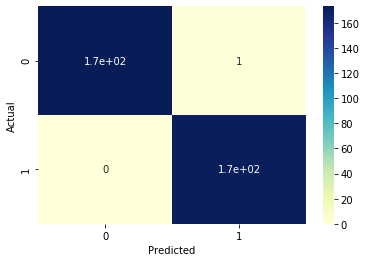

In [477]:
X = pc_training_data[['f1','f2','f3','f4','f5']]
Y = pc_training_data[['label']]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size = 0.9)
pc_logit = LogisticRegression()
pc_logit.fit(X_train, Y_train.values.ravel())
Y_pred = pc_logit.predict(X_test)
pc_matrix = pd.crosstab(Y_test.values.ravel(), Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(pc_matrix, annot=True, cmap="YlGnBu")

In [478]:
metrics.accuracy_score(Y_test.values.ravel(), Y_pred)

0.9971098265895953

In [499]:
pc_logit.coef_

array([[7.8224008 , 8.45701683, 0.18023379, 0.08606977, 0.40737967]])

#### Raw Data Result

In [450]:
spacy_percent = [element.replace("%"," %") for i, element in enumerate(spacy_percentage)]

In [463]:
## create snippet column in percentage values
spacy_snippet = []

for i, element in enumerate(spacy_percent):
    
    ## status monitor
    if (i % 1000 == 0):
        print(i)
    
    result = find_name_match(element, text)
    if (result != 0):
        sni = create_snippet(result, text)
    else:
        sni = ''
    spacy_snippet.append(sni)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [479]:
len(spacy_percent)

10002

In [480]:
len(spacy_snippet)

10002

In [481]:
len(spacy_cardinal)

16802

In [482]:
len(spacy_cardinal_snippet)

16802

In [483]:
pc_name = spacy_percent + spacy_cardinal

In [484]:
pc_snippet = spacy_snippet + spacy_cardinal_snippet

In [485]:
pc_df = pd.DataFrame(list(zip(pc_name,pc_snippet)), 
                      columns =['name', 'snippet'])

In [487]:
pc_df = pc_df[pc_df['snippet'] != '']
pc_df = pc_df.reset_index(drop=True)

In [489]:
pc_df.head(5)

,name,snippet
0,1.2 %,'s trading right high day Hong Kong 1.2 % EAR...
1,47 %,-- Congress Just Socked It To The 47 % The Se...
2,39.6 %,$ 450000 -- even much back Clinton-era 39.6 %...
3,4.2 %,Senate agreed raise payroll tax working Ameri...
4,35 %,year — see income tax rise modestly 35 % 39.6...


In [490]:
pc_df['f1'] = pc_df.apply(pc_f1, axis=1)
pc_df['f2'] = pc_df.apply(pc_f2, axis=1)
pc_df['f3'] = pc_df.apply(pc_f3, axis=1)
pc_df['f4'] = pc_df.apply(pc_f4, axis=1)
pc_df['f5'] = pc_df.apply(pc_f5, axis=1)

In [491]:
pc_df_x = pc_df[['f1','f2','f3','f4','f5']]
pc_df_y = pc_logit.predict(pc_df_x)
pc_df['decision'] = pc_df_y
pc_df_result = pc_df[pc_df['decision'] == 1]
pc_feature = ['f1','f2','f3','f4','f5']
for i in pc_feature:
    print(pc_df_result[i].mean())

0.40831408775981526
0.5914549653579677
0.14503464203233257
0.060277136258660505
2.338568129330254


In [492]:
len(pc_df_result.name)

4330

In [493]:
## output

pc_df_result.to_csv('C:/Users/James Jia/Desktop/HW3/output/all_percentage.csv', 
                    columns = ['name'], index=False, header=False)

## end of assignment